# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

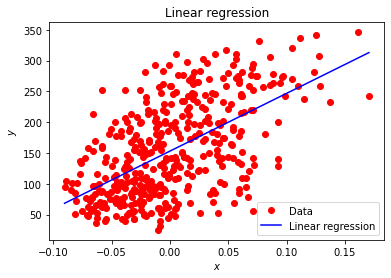

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

The definitions of "Deep learning" by Goodfellow et al. were used.[1]

The Mean Squared Error of the estimate of a parameter has the following definition:
$$
\text{MSE}(\hat{\theta}_m) = \mathbb{E}\left[ (\hat{\theta}_m - \theta)^2 \right]
$$

The Bias is defined as follows:
$$
\text{Bias}(\hat{\theta}_m) = \mathbb{E}[\hat{\theta}_m] - \theta
$$

And the Variance has the following definition:
$$
\text{Var}(\hat{\theta}_m) = \mathbb{E}\left[ (\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m])^2 \right]
$$
\
\
\
\

With these definitions it can be shown that by adding and subtracting $\mathbb{E}[\hat{\theta}_m]$ inside the term:


$$
\text{MSE}(\hat{\theta}_m) = \mathbb{E}\left[ (\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m] + \mathbb{E}[\hat{\theta}_m] - \theta)^2 \right]
$$

Then the square is extended:

$$
\text{MSE}(\hat{\theta}_m) = \mathbb{E}\left[ (\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m])^2 + 2(\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m])(\mathbb{E}[\hat{\theta}_m] - \theta) + (\mathbb{E}[\hat{\theta}_m] - \theta)^2 \right]
$$

Noting that $\mathbb{E}[\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m]] = 0$, it is gotten that $\mathbb{E}[2(\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m])(\mathbb{E}[\hat{\theta}_m] - \theta)] = 0$, so the equation can be rewritten as:

$$
\text{MSE}(\hat{\theta}_m) = \mathbb{E}\left[ (\hat{\theta}_m - \mathbb{E}[\hat{\theta}_m])^2 \right] + (\mathbb{E}[\hat{\theta}_m] - \theta)^2
$$

Together with the definitions of Bias and Variance, this simplifies to:

$$
\text{MSE}(\hat{\theta}_m) = \text{Var}(\hat{\theta}_m) + \text{Bias}(\hat{\theta}_m)^2
$$

So it is shown that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance.

**Citation:**

[1]Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. *Deep Learning*. MIT Press, 2016. Available at: [http://www.deeplearningbook.org](http://www.deeplearningbook.org).


### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

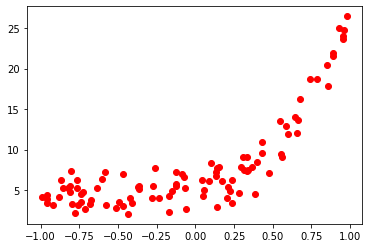

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

#### Answer question polynomial regression
When the model complexity increases, which in this case is when the degree of the polynomial increases, the bias will decrease. The variance on the other hand will increase with increasing model complexity.

In other words, complex models with a high order polymial will have a high variance. Simple models with a low order polynomial, will have a high bias.

the best degree of the polynomial on the Generated data is 3 and the R2 score on a test set is 0.9096814715204851


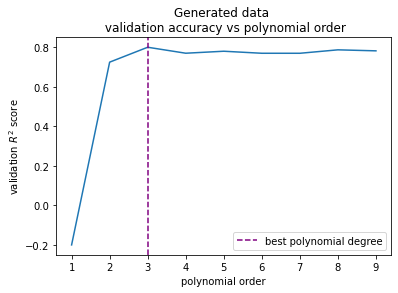

the best degree of the polynomial on the Diabetes data is 2 and the R2 score on a test set is 0.24578368594743127


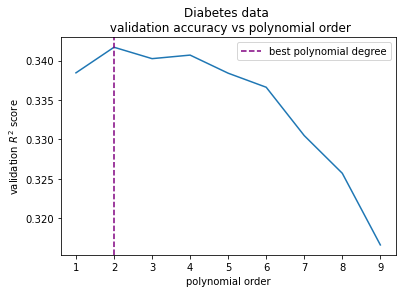

In [20]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def polynomial_regression_analysis(X,y,number_of_degrees, plot_name):
    """
    Perform polynomial regression analysis and 
    visualize the validation R2 score as a function of the polynomial order
    X: input data
    y: target values
    number_of_degrees: number of degrees for the polynomial to test
    plot_name: name to add to plot
    """
    # split the data and targets into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

    # define a pipeline with 3 steps; scaling, polynomial features, and linear regression
    model = Pipeline([
                      ("scaler", StandardScaler()),
                      ("poly", PolynomialFeatures()),
                      ("regression", LinearRegression())
                     ])
    # define a grid search for the best polynomial degree 
    param_grid = {
        'poly__degree': list(range(1,number_of_degrees)) 
    }

    # use GridSearchCV to find the best degree for the polynomial
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='r2', error_score='raise')

    # train GridSearchCV  on the training dataset
    grid_search.fit(X_train, y_train)

    # get the best polynomial degree and model
    best_degree = grid_search.best_params_['poly__degree']
    best_model = grid_search.best_estimator_

    # make predictions using the best model on the test data
    y_pred = best_model.predict(X_test)

    # evaluate the model's performance on an independent test set using R2 score
    r2 = r2_score(y_test, y_pred)

    print(f'the best degree of the polynomial on the {plot_name} is', best_degree, 
          'and the R2 score on a test set is',r2)

    # get the results from the grid search
    results = grid_search.cv_results_

    # get the polynomial degrees and test scores from the grid search results
    degrees = results['param_poly__degree']
    mean_test_scores = results['mean_test_score']  

    # Plot the test score results (validation accuracy) as a function of the degree (polynomial order)
    plt.figure()
    plt.plot(degrees, mean_test_scores)
    plt.xlabel('polynomial order')
    plt.ylabel('validation ' r'$R^2$' ' score')
    plt.title (f'{plot_name} \n validation accuracy vs polynomial order')
    plt.axvline(x=best_degree, color='purple',ls='--', label='best polynomial degree')
    plt.legend()
    plt.show()

# experiment with generated data
X_generated, y_generated = generate_dataset(n=100, degree=4, noise=1.5)
# reshape X to fit the model
X_generated = X_generated[:, np.newaxis]
polynomial_regression_analysis(X_generated,y_generated,10, 'Generated data')

# experiment with diabetes dataset
X_diabetes = diabetes.data[:, np.newaxis, 2]
y_diabetes = diabetes.target
polynomial_regression_analysis(X_diabetes,y_diabetes,10, 'Diabetes data')

the best degree of the polynomial is 4 and the R2 score on a test set is 0.9644465363514554

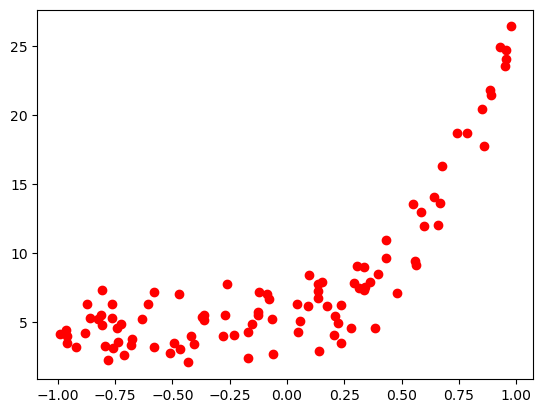
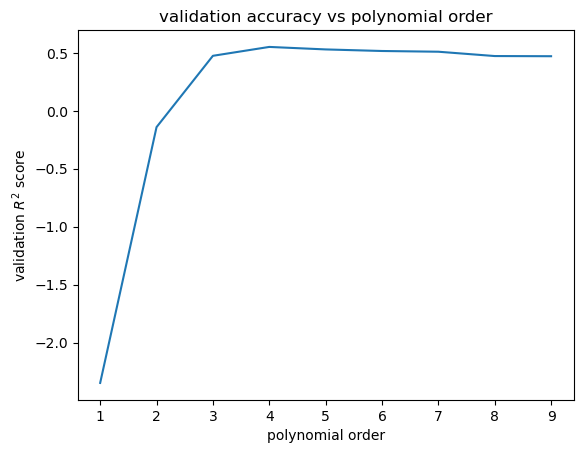

the best degree of the polynomial is 2 and the R2 score on a test set is 0.24578368594743139
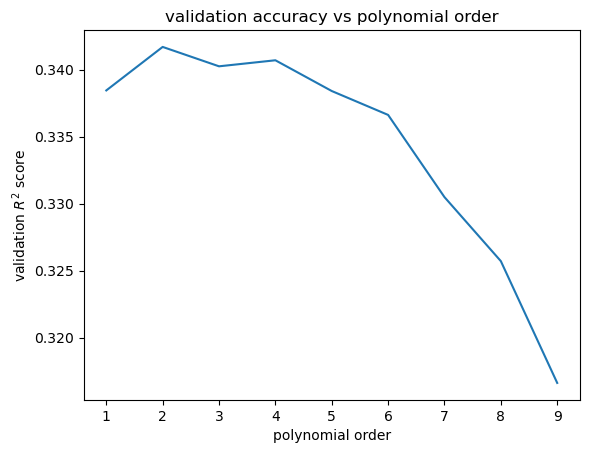

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

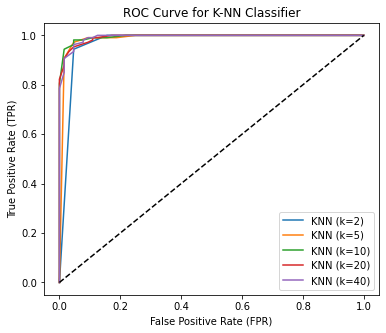

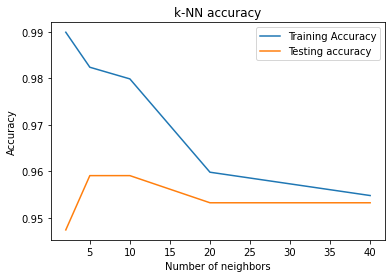

The negative ratio is: 0.37258347978910367 
While the positive ratio is 0.6274165202108963


In [9]:
### TO DO : (Move to functions file) #######
def knn_classfier(k, X, y):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scaler = StandardScaler()
    model_knn = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])  
    
    # train the model using the training dataset
    model_knn.fit(X, y)  
    return model_knn

#####################################

from sklearn.metrics import roc_curve
import collections

# Import data
breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state=27)

# Initialize list were accuracies are saved
train_acc = []
test_acc = []

# Innitialize which k-nn models are analyzed
neighbors_ = [2, 5, 10, 20, 40] 

plt.figure(figsize=(6, 5))  

# Loop over all K-nn models
for k in neighbors_:
    # Make the k-nn model
    model_knn = knn_classfier(k, X_train, y_train)
    
    # Get accuracies
    train_acc.append(model_knn.score(X_train, y_train))
    test_acc.append(model_knn.score(X_test, y_test))
    
    # Make ROC curve data
    y_pred_proba = model_knn.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'KNN (k={k})')

# Draw dotted reference line
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and title and legend
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for K-NN Classifier')
plt.legend()
plt.show()
    
#Make accuracies plot
plt.title('k-NN accuracy')
plt.plot(neighbors_, train_acc, label='Training Accuracy')
plt.plot(neighbors_, test_acc, label='Testing accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Calculate ration of y
counter = collections.Counter(y)
negative_ratio = counter[0]/len(y)
postive_ratio = counter[1]/len(y)
print("The negative ratio is:", negative_ratio,"\nWhile the positive ratio is", postive_ratio)

#### ROC Curve Analysis

The ROC curve is plotted for 5 differen K-nn models, each with a different number of neigbours (2, 5, 10, 20 and 40). In general we can see that all models peform well since their main curve is most concentrated in the upper left corner. This is supported further by the accuracy plot, where the accuracy remains high for both the training as wel ass the testing accuracy regardless of number of neighbours.

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


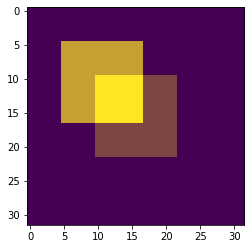

In [10]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

The Dice similarity coefficient and the $F_1$ score are both metrics used to evaluate the performance of models, especially in bianary classification and image segmentation tasks. They both yield values between 0 and 1, where 1 indicates perfect overlap between predicted and ground truth data, and 0 indicates no overlap at all.

Dice similarity coefficient measures the similarity between two sets $A$ and $B$ and is defined as:

$$ DSC(A, B) = \frac{2|A \cap B|}{|A| + |B|} $$

Where:
- $ |A| $ is the size of the ground truth positives
- $ |B| $ is the size of the predicted positives
- $ |A \cap B|$ is the number of true positives predicted

In terms of classification:
- $ |A| = TP + FN $
- $ |B| = TP + FP $ 
- $ |A \cap B|$ $ = TP $

$T$ meaning true, $F$ meaning false, $P$ meaning positive, and $N$ meaning negative.

<br>

This definiton of $A$ and $B$ is further illustrated in the figure at the end of this explanation.

<br>


Precision and Recall are defined as the accuracy of positive predictions and the ability to find all actual positive instances respectively, given by:
$$ Precision = \frac{TP}{TP + FP} $$
$$ Recall = \frac{TP}{TP + FN} $$

and the harmonic mean can be defined as simply the reciprocal of the average of the reciprocals.

Thus, $F_1$ score is the harmonic mean of precision and recall:

$$
F_1 = 2 \times \frac{P \times R}{P + R}
$$

Substitution of the definitions for precision and recall into this formula results in:
$$
F_1 = \frac{2 TP}{2TP + FP + FN}
$$

Which is equivalent to the formula of the DSC.

To conclude, both the DSC and the $F_1$ score simplify to the same formula, making them mathematically equivalent in binary classification contexts. This equivalence holds true because both metrics focus on the overlap between predicted and ground truth positives.

![Drawing Matrix.jpg](<attachment:Drawing Matrix.jpg>)
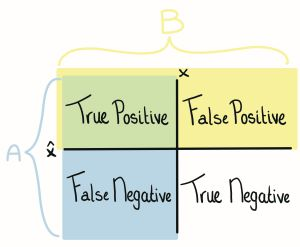